In [1]:
#importing necessary python packages
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir('C:\\RESEARCH\\LUAD\\Regression') #setting the right directory

In [3]:
# Importing the dataset
dt = pd.read_excel('Flux Clinical.xlsx',index_col=0)


In [4]:
dt.shape

(517, 2309)

In [5]:
dt.head(2)

,'3DSPHR','3HBCOAHLm','ABTArm','ABTD','ACACT1r','ACACT1rm','ACACT1x','ACOAD9m','ACOAO7p','ACOATA',...,Tissue Source Site_NJ,Tissue Source Site_O1,Tissue Source Site_S2,Person Neoplasm Status_TUMOR FREE,Person Neoplasm Status_WITH TUMOR,Vial number_A,Vial number_B,Patient's Vital Status_Alive,Patient's Vital Status_Dead,Overall Survival (Months)
HUG0_SYMBOL,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,11.448262,154.187481,-583.764387,-14.237357,125.403072,235.338244,457.654536,74.716367,72.493260,-165.591744,...,0,0,0,1,0,1,0,1,0,0.00
TCGA-05-4249-01,9.173955,162.200877,-442.863722,-5.338254,128.134267,137.492687,149.939274,75.026103,56.620656,-73.252506,...,0,0,0,1,0,1,0,1,0,50.03


In [6]:
del dt['Column1']
del dt['Patient\'s Vital Status_Dead']
del dt['Patient\'s Vital Status_Alive']

In [7]:
X = dt.iloc[:,0:2304].values
y = dt.iloc[:, -1].values

In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [10]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.fit_transform(X_val)

In [12]:
sc_y = StandardScaler()
y_train = np.squeeze(sc_y.fit_transform(y_train.reshape(-1, 1)))
y_val = np.squeeze(sc_y.transform(y_val.reshape(-1, 1)))
y_test = np.squeeze(sc_y.transform(y_test.reshape(-1, 1)))

In [13]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()

regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [14]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [15]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))



28.717657954800195
1355.8538157590435
36.82192031601616
Variance score: -1.48


R^2 = -1.4815


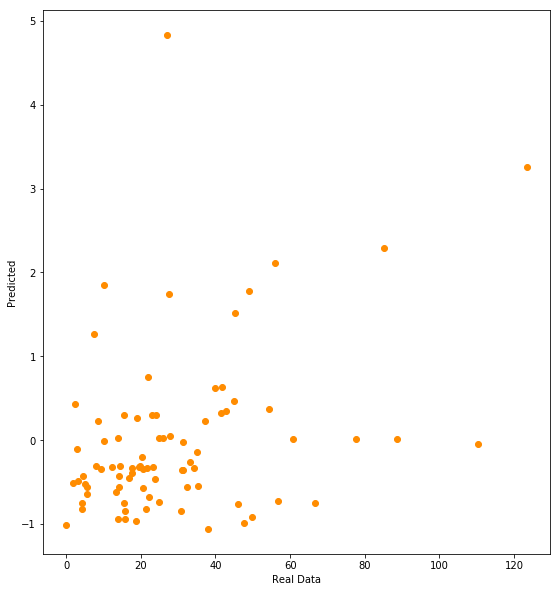

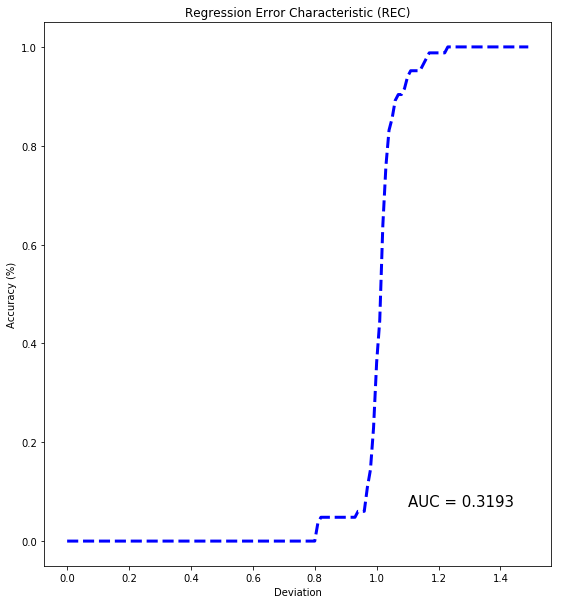

In [17]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [23]:
# GRID SEARCH
from sklearn.model_selection import GridSearchCV

param_grid = {  'min_samples_split':[0.1,0.5,1.0,2,5,7,10,25],
                  "max_depth": [1,2,3,4,5,6,7]
                 }  

In [24]:
regressor = DecisionTreeRegressor()
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10)
grid_search = grid.fit(X_train, y_train)

In [25]:
print(grid_search.best_score_, grid_search.best_params_)

0.10048475560397338 {'max_depth': 4, 'min_samples_split': 1.0}


In [26]:
# Fitting Random Forest Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth = 4, min_samples_split = 1.0)

regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=1.0, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [27]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [28]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))

0.6822044466409322
0.8589846670544914
0.9268142570410165
Variance score: 0.14
